# Model the time evolution of the Fried parameter $r_{0}$ in Pachon DIMM data

## jupyter boilerplate

Imports of python modules I usually want when working a a jupyter notebook.

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple
from functools import partial
from datetime import datetime, timedelta

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
# importing easyaccess resets some pandas parameters to unfortunate values
pd.options.display.max_rows = 10

import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import AR
from scipy.stats import anderson_ksamp
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols as formula_ols

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)


/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load the Pachon DIMM data

The data from the DIMM Pachon loaded here was provided to me by Edison Bustos in email on 2018-03-21. It contains time stamps and seeing estimates from Pachon DIMM data. These estimates arise from an equation that assumes Kolmogorov seeing, and are calculated for a wavelongth of 500nm. See equation 5 of Tokovinin 2002 (2002PASP..114.1156T).

### Read the raw data

The email included two separate files with diffirent date ranges. Read both and merge them.

In [2]:
raw_dimm_old = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/pachon.Pachon_seeing-2004-2016.txt.bz2', sep="\t", parse_dates=[0])
raw_dimm_old.drop('meandx', axis=1, inplace=True)
raw_dimm_old.columns = ['time', 'seeing']
raw_dimm_new = pd.read_table('/data/des70.a/data/neilsen/obs_strat/data/PachonSM.DIMM-2016-2018.txt.bz2', sep="\t", parse_dates=[0])
raw_dimm = pd.concat([raw_dimm_old, raw_dimm_new])
raw_dimm.sort_values('time', ascending=True, inplace=True)
raw_dimm.set_index('time', inplace=True)
raw_dimm = raw_dimm.groupby(level=0).mean()
raw_dimm.head()

,seeing
time,
2004-03-17 02:33:15,0.71
2004-03-17 02:34:35,0.74
2004-03-17 02:35:42,0.74
2004-03-17 02:36:49,0.75
2004-03-17 02:37:58,0.72


In [3]:
raw_dimm.tail()

,seeing
time,
2018-03-21 10:01:24,0.7050
2018-03-21 10:02:27,0.6980
2018-03-21 10:03:30,0.7110
2018-03-21 10:04:34,0.7210
2018-03-21 10:05:17,0.7645


### Filter out unreasonable values

In [4]:
raw_dimm.query('(seeing < 5) & (seeing > 0.1)', inplace=True)

### Calculate $r_{0}$

Rather than use the seeing estimate from the Kolmogorov-derived equation, use the Fried paramater.

In [5]:
raw_dimm['r0'] = 0.98*5e-7/np.radians(raw_dimm.seeing/(60*60))
raw_dimm['log_r0'] = np.log10(raw_dimm.r0)

### Calculate von Karman seeing

Tokovinin 2002 provides an equation (eqn 19) that approximates the seeing for a given Fried paramater assuming a von Karman model. This model requires an estime of the outer scale of the seeing, $L_0$. A value for $L_0$ is poorly known; the only estimate I can find is from Ziad et al 2000 (2000ApOpt..39.5415Z), which gives a value of 28.4 -13.3/+25.0 meters. I will use a value of 30 meters.

In [6]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.813*np.power(r0/outer_scale, 0.356) )
    return fwhm

raw_dimm['vk_seeing'] = calc_FWHM_vK(raw_dimm.seeing, 30)

In [7]:
raw_dimm.describe()

,seeing,r0,log_r0,vk_seeing
count,1.160434e+06,1.160434e+06,1.160434e+06,1.160434e+06
mean,8.834132e-01,1.286241e-01,-9.148330e-01,6.940753e-01
std,3.431807e-01,4.293256e-02,1.480070e-01,3.023545e-01
min,1.010000e-01,2.038930e-02,-1.690598e+00,4.060876e-02
25%,6.600000e-01,9.918524e-02,-1.003553e+00,4.984043e-01
50%,8.100000e-01,1.247775e-01,-9.038638e-01,6.276740e-01
75%,1.019000e+00,1.531360e-01,-8.149227e-01,8.099793e-01
max,4.957000e+00,1.000691e+00,2.998394e-04,4.406898e+00


### Plot the time series

First, set some date columns to make plotting more convenient.

In [8]:
raw_dimm['month'] = raw_dimm.index.month
raw_dimm['year'] = raw_dimm.index.year
raw_dimm['data_month'] = 12*(raw_dimm.year - np.min(raw_dimm.year)) + raw_dimm.month

I'll start by just plotting the time series, averaged by month. 

I plot include a [lowess](https://en.wikipedia.org/wiki/Local_regression) smoothed curved through the points, which just estimates a smooth function by doing linear fits to nearby points.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5f14cf0dd8> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5f14cf1fd0> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0,0.5,'FWHM (asec)')

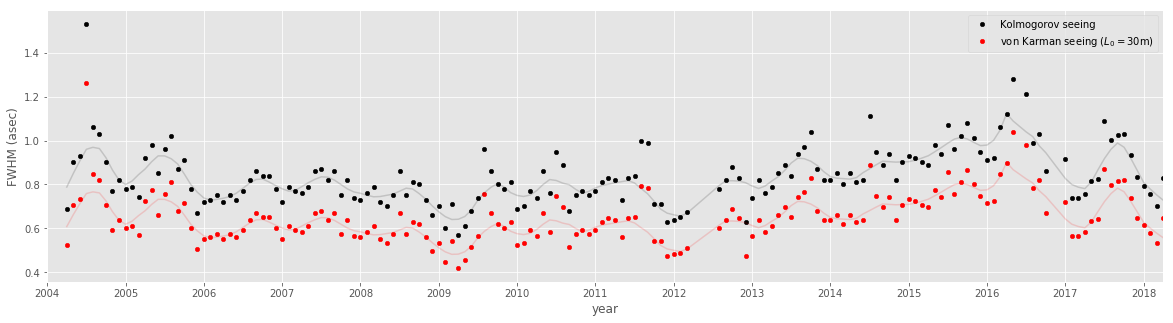

In [9]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = raw_dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(raw_dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Make a similar plot for the Fried parameter:

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5f14bdeda0> has a label of '_no_label_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Text(0,0.5,'Fried parameter $r_0$ (meters)')

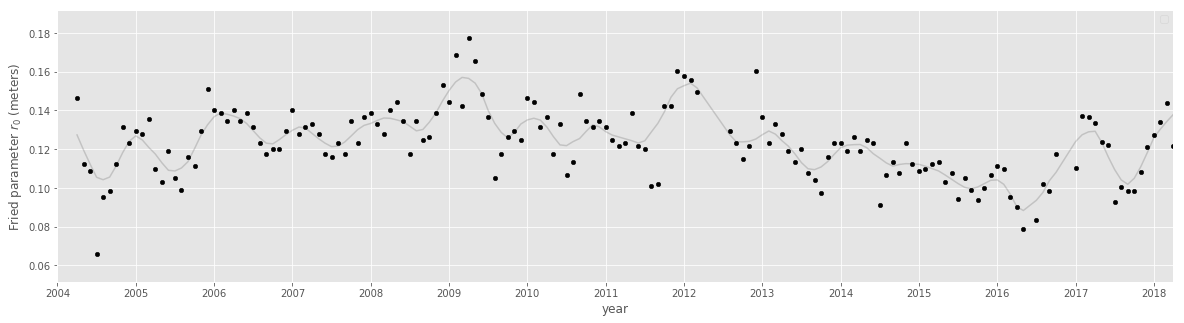

In [10]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = raw_dimm.groupby('data_month').agg({'r0': 'median'}).reset_index()
df.plot.scatter('data_month', 'r0', color='black', ax=axes)

df['r0_lowess'] = lowess(df.r0, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'r0_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 180, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(raw_dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('Fried parameter $r_0$ (meters)')

## Check the distributions

The time series modeling I indend to do works best with data that are normally distributed. Check the distribution of data we actually have.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-4.8565255 , -4.67779401, -4.58119483, ...,  4.58119483,
          4.67779401,  4.8565255 ]),
  array([ -1.69059771e+00,  -1.69042245e+00,  -1.68778502e+00, ...,
          -3.67714720e-02,  -3.67714720e-02,   2.99839422e-04])),
 (0.14702806716053932, -0.91483300166423875, 0.99338166858656241))

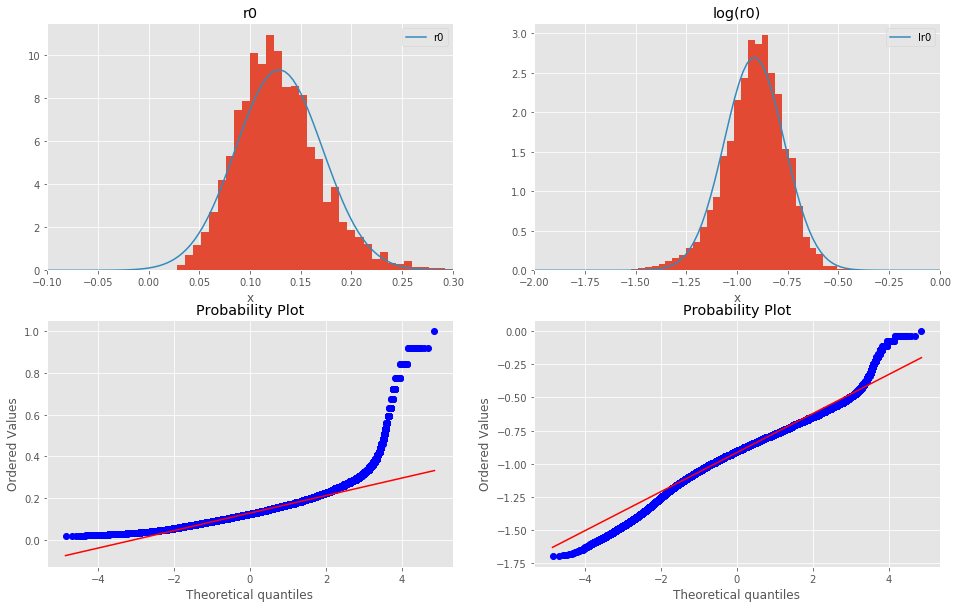

In [11]:
mpl.rcParams['figure.figsize'] = (16, 10)
fig, axes = plt.subplots(2,2)

axes[0,0].set_title('r0')
raw_dimm.r0.hist(bins=50, range=(-0.1,0.3), normed=True, ax=axes[0,0])
r0_norm_fit = scipy.stats.norm.fit(raw_dimm.r0)
x = np.linspace(-0.1, 0.3, 100)
r0_fit = pd.DataFrame({'x': x,
                       'r0': scipy.stats.norm.pdf(x, loc=r0_norm_fit[0], scale=r0_norm_fit[1])})
r0_fit.plot('x', 'r0', ax=axes[0,0])
scipy.stats.probplot(raw_dimm.r0, dist=scipy.stats.norm, plot=axes[1,0])

axes[0,1].set_title('log(r0)')
raw_dimm.log_r0.hist(bins=50, normed=True, ax=axes[0,1])

lr0_norm_fit = scipy.stats.norm.fit(raw_dimm.log_r0)
x = np.linspace(-2, 0, 100)
lr0_fit = pd.DataFrame({'x': x,
                       'lr0': scipy.stats.norm.pdf(x, loc=lr0_norm_fit[0], scale=lr0_norm_fit[1])})
lr0_fit.plot('x', 'lr0', ax=axes[0,1])

scipy.stats.probplot(raw_dimm.log_r0, dist=scipy.stats.norm, plot=axes[1,1])

In [12]:
scipy.stats.normaltest(raw_dimm.r0), scipy.stats.normaltest(raw_dimm.log_r0)

(NormaltestResult(statistic=370066.27518656279, pvalue=0.0),
 NormaltestResult(statistic=53347.29954422194, pvalue=0.0))

In [13]:
df = raw_dimm.sample(1000)
scipy.stats.normaltest(df.r0), scipy.stats.normaltest(df.log_r0)

(NormaltestResult(statistic=54.089248253886247, pvalue=1.797500320624349e-12),
 NormaltestResult(statistic=46.71262778947905, pvalue=7.1859097408400924e-11))

Okay, neither are really Gaussian, but $\log(r_{0})$ is closer to normal than $r_{0}$. One notable feature is the low-value tail of $log(r_0)$. This suggests that there is a poor-seeing tail of the distribution that my model will not be able to model well.

## Resample on 5 minute intervals

In [14]:
resampled_time_index = pd.date_range(raw_dimm.index.min().floor('5Min'), raw_dimm.index.max().ceil('5Min'), freq='5Min')
dimm = pd.DataFrame(raw_dimm.reindex(resampled_time_index, method='nearest', limit=1, tolerance='150Sec'))
dimm.index.rename('time', inplace=True)
dimm

,seeing,r0,log_r0,vk_seeing,month,year,data_month
time,,,,,,,
2004-03-17 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-17 02:35:00,0.7400,0.136581,-0.864611,0.567158,3.0,2004.0,3.0
2004-03-17 02:40:00,0.8800,0.114852,-0.939861,0.688482,3.0,2004.0,3.0
2004-03-17 02:45:00,0.7000,0.144385,-0.840477,0.532723,3.0,2004.0,3.0
2004-03-17 02:50:00,0.7600,0.132987,-0.876192,0.584417,3.0,2004.0,3.0
...,...,...,...,...,...,...,...
2018-03-21 09:50:00,0.7550,0.133867,-0.873326,0.580100,3.0,2018.0,171.0
2018-03-21 09:55:00,0.7440,0.135846,-0.866952,0.570608,3.0,2018.0,171.0
2018-03-21 10:00:00,0.7220,0.139986,-0.853916,0.551649,3.0,2018.0,171.0


## Simple new columns

In [15]:
resampled_times = pd.Series(dimm.index, index=dimm.index)
dimm['mjd'] = dimm.index.to_julian_date() - 2400000.5
dimm['month'] = dimm.index.month
dimm['year'] = dimm.index.year
dimm['yday'] = resampled_times.apply(lambda t: t.timetuple().tm_yday)

## Add a night column

In [16]:
ctio_night_shift = (180.0-70.8062)/360.0
dimm['night'] = np.floor(dimm.mjd + ctio_night_shift).astype(int) - np.floor(np.min(dimm.mjd + ctio_night_shift - 1)).astype(int)

## Mark halves of nights

In [17]:
dimm['am'] = ((dimm.mjd + ctio_night_shift) % 1) > 0.5

In [18]:
# dimm = pd.read_pickle('/data/des70.a/data/neilsen/obs_strat/data/pachon_dimm.pickle')

## Add the solar zenith distance

Anecdotal experience suggests that the seeing may be poorer shortly after sundown. Calculate the zenith distance of the sun for each sample so these points can be cleanly identified. 

In [19]:
pachon = EarthLocation.of_site('Cerro Pachon')
def solar_zd(t):
    assert t.values.dtype.str[-3:-1] == 'ns'
    ap_times = astropy.time.Time(t.values.view('i8') * u.ns, format='unix')
    solar_gcrs = get_sun(ap_times)
    time_altaz_coords = AltAz(obstime=ap_times, location=pachon)
    solar_altaz = solar_gcrs.transform_to(time_altaz_coords)
    assert solar_altaz[0].alt.unit == u.degree
    zd = 90 - solar_altaz.alt.value
    return zd

try:
    reloaded_dimm = pd.read_pickle('/data/des70.a/data/neilsen/obs_strat/data/pachon_dimm_withsun.pickle')
    assert (reloaded_dimm.mjd == dimm.mjd).all()
    dimm['solar_zd'] = reloaded_dimm['solar_zd']
except:
    dimm['solar_zd'] = solar_zd(dimm.index)
    dimm.to_pickle('/data/des70.a/data/neilsen/obs_strat/data/pachon_dimm_withsun.pickle')

## Flag twilight values

In [20]:
dimm['twilight'] = dimm.solar_zd < 108.0
dimm['twilight24'] = dimm.solar_zd < 114.0

## Take a look at the result

In [21]:
dimm.head()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,yday,night,am,solar_zd,twilight,twilight24
time,,,,,,,,,,,,,,
2004-03-17 02:30:00,NaN,NaN,NaN,NaN,3,2004,NaN,53081.104167,77,1,False,133.917644,False,False
2004-03-17 02:35:00,0.74,0.136581,-0.864611,0.567158,3,2004,3.0,53081.107639,77,1,False,134.778300,False,False
2004-03-17 02:40:00,0.88,0.114852,-0.939861,0.688482,3,2004,3.0,53081.111111,77,1,False,135.624071,False,False
2004-03-17 02:45:00,0.70,0.144385,-0.840477,0.532723,3,2004,3.0,53081.114583,77,1,False,136.454055,False,False
2004-03-17 02:50:00,0.76,0.132987,-0.876192,0.584417,3,2004,3.0,53081.118056,77,1,False,137.267298,False,False


In [22]:
dimm.describe()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,yday,night,solar_zd
count,281263.000000,281263.000000,281263.000000,281263.000000,1.473789e+06,1.473789e+06,281263.000000,1.473789e+06,1.473789e+06,1.473789e+06,1.473789e+06
mean,0.882928,0.128871,-0.914337,0.693674,6.520395e+00,2.010713e+03,82.158339,5.563976e+04,1.830750e+02,2.559568e+03,9.025772e+01
std,0.344246,0.043579,0.148842,0.303266,3.448645e+00,4.054884e+00,48.858239,1.477244e+03,1.054486e+02,1.477244e+03,4.081739e+01
min,0.101000,0.020686,-1.684332,0.040609,1.000000e+00,2.004000e+03,3.000000,5.308110e+04,1.000000e+00,1.000000e+00,6.804737e+00
25%,0.660000,0.099088,-1.003979,0.498404,4.000000e+00,2.007000e+03,39.000000,5.436043e+04,9.200000e+01,1.280000e+03,5.594808e+01
50%,0.810000,0.124777,-0.903864,0.627674,7.000000e+00,2.011000e+03,74.000000,5.563976e+04,1.830000e+02,2.560000e+03,9.018764e+01
75%,1.020000,0.153136,-0.814923,0.810857,1.000000e+01,2.014000e+03,124.000000,5.691909e+04,2.740000e+02,3.839000e+03,1.244769e+02
max,4.886000,1.000691,0.000300,4.340810,1.200000e+01,2.018000e+03,171.000000,5.819842e+04,3.660000e+02,5.118000e+03,1.732000e+02


## Variation by time of night

Note that a difference in $\ln(r_{0})$ corresponds to a ratio of $r_{0}$.

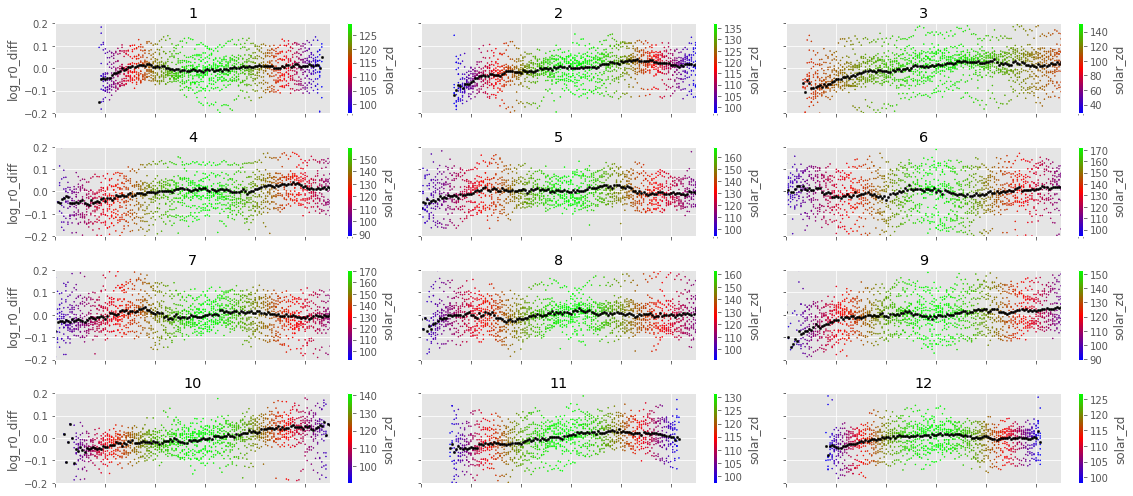

In [23]:
mpl.rcParams['figure.figsize'] = (16, 7)
fig, axes = plt.subplots(4,3)
for i, (m, df) in enumerate(dimm.groupby('month')):
    df = df.copy()
    df['t'] = np.floor((dimm.mjd + ctio_night_shift - np.floor(dimm.mjd + ctio_night_shift))*24*12)/12
    df['log_r0_diff'] = df.log_r0 - np.mean(df.log_r0)
    c = int(i % 3)
    r = int(i / 3)
    df.groupby(['year', 't'])['log_r0_diff', 'solar_zd'].mean().reset_index().plot.scatter('t', 'log_r0_diff', c='solar_zd', s=1, ylim=(-0.2, 0.2), xlim=(6, 17), sharex=True, sharey=True, ax=axes[r, c], cmap='brg')
    df.groupby(['t'])['log_r0_diff', 'solar_zd'].mean().reset_index().plot.scatter('t', 'log_r0_diff', s=5, c='black', ax=axes[r, c])
    axes[r, c].set_title(str(m))
    
plt.tight_layout()

It does look it me like there is something going on at the beginnings of nights is some but not all months, but the scatter is large. For the moment, I will not attempt to model this, but it will go in the to-do list for future improvements.

# Global averages by month

Now, I will take a look at seasonal variations by looking at the distributions by month.

In the boxplots below, the central blue line shows the median of the mothly medians of the data, and the box show the central two quaritles. The whiskers show the full range of the data, excluding outliers.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


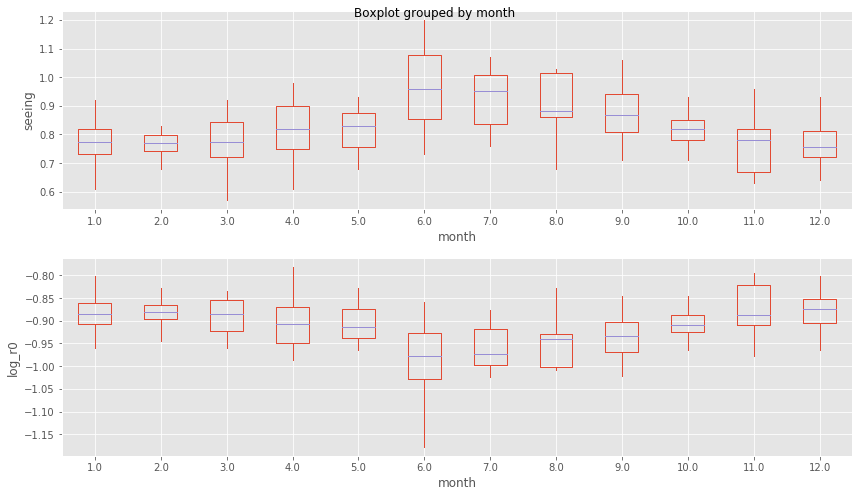

In [24]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
dimm.groupby('data_month').median().boxplot('log_r0', 'month', showfliers=False, showcaps=False, ax=axes[1])
dimm.groupby('data_month').median().boxplot('seeing', 'month', showfliers=False, showcaps=False, ax=axes[0])

# Label the data on the y axis, not the top
for ax in axes:
    ax.set_ylabel(ax.get_title())
    ax.set_title('')

plt.tight_layout()

The seeing is obviously worse in June, July and August than in December, January, and February.

# Global mean by day of year

I also take a look at variation by day of the year.

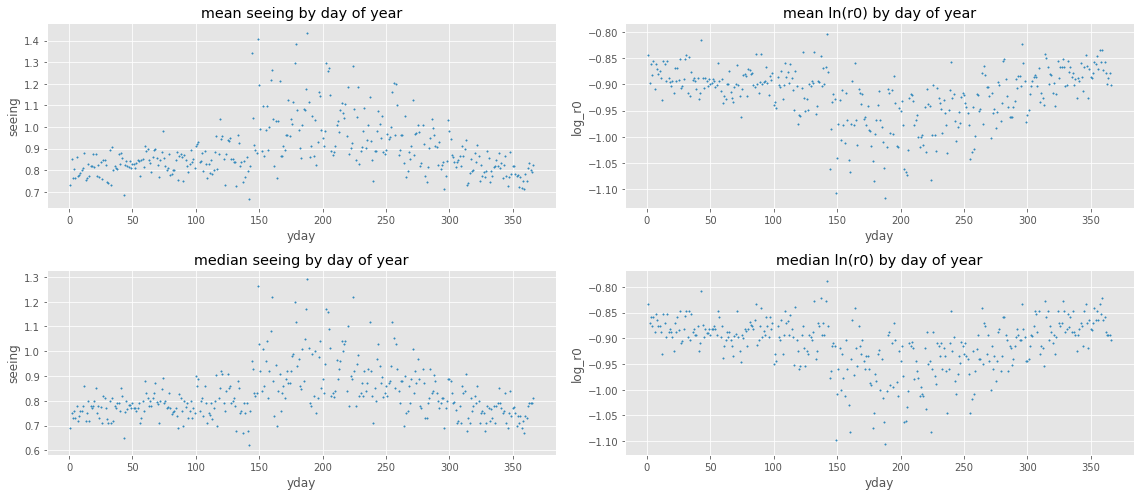

In [25]:
mpl.rcParams['figure.figsize'] = (16, 7)
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('mean seeing by day of year')
dimm.groupby(['yday'])['seeing'].mean().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[0,0])
axes[0,1].set_title('mean ln(r0) by day of year')
dimm.groupby(['yday'])['log_r0'].mean().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[0,1])
axes[1,0].set_title('median seeing by day of year')
dimm.groupby(['yday'])['seeing'].median().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[1,0])
axes[1,1].set_title('median ln(r0) by day of year')
dimm.groupby(['yday'])['log_r0'].median().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[1,1])
plt.tight_layout()

# Autocorrelation function of the nightly mean

Finally, the autocorrelation function shows a clearly oscillating long term correlation.

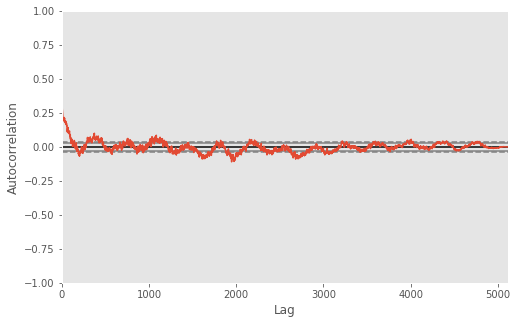

In [26]:
mpl.rcParams['figure.figsize'] = (8, 5)
df = dimm.groupby('night')['log_r0'].mean().reset_index().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0)

# Fitting the yearly variation to a sine

While clearly present, the scatter in the data is large enough that complex models seem unwarranted; I will start with a simple sine, fit to the data using simple linear regress and the harmonic addition theorem.

In [27]:
df = dimm.query('~ twilight24').copy()
#df = dimm.copy()
df['cos'] = np.cos(df.mjd*2*np.pi/365.24217)
df['sin'] = np.sin(df.mjd*2*np.pi/365.24217)
trig_fit = formula_ols('log_r0 ~ cos + sin', data=df).fit()
trig_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_r0   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     5942.
Date:                Tue, 17 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:25:52   Log-Likelihood:             1.1236e+05
No. Observations:              219853   AIC:                        -2.247e+05
Df Residuals:                  219850   BIC:                        -2.247e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9170      0.000  -2941.256      0.000      -0.918      -0.916
cos            0.0221      0.000     49.407      0.000       0.021       0.023
sin            0.0430      0.000     99.238      0.000       0.042       0.044
==============================================================================
Omnibus:                     7423.539   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10607.192
Skew:                          -0.350   Prob(JB):                         0.00
Kurtosis:                       3.817   Cond. No.                         1.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
df.describe()

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,yday,night,solar_zd,cos,sin
count,219853.000000,219853.000000,219853.000000,219853.000000,492273.000000,492273.000000,219853.000000,492273.000000,492273.000000,492273.000000,492273.000000,492273.000000,492273.000000
mean,0.881680,0.129094,-0.913598,0.692601,6.411727,2010.678997,81.601238,55623.777474,179.691482,2543.580824,136.795083,-0.115234,-0.077502
std,0.345499,0.043537,0.149021,0.304421,3.139459,4.052790,48.761932,1477.306842,95.843914,1477.306786,15.357638,0.695031,0.705442
min,0.101000,0.021220,-1.673259,0.040609,1.000000,2004.000000,3.000000,53081.104167,1.000000,1.000000,114.000003,-1.000000,-1.000000
25%,0.660000,0.100069,-0.999700,0.498404,4.000000,2007.000000,39.000000,54331.388889,103.000000,1251.000000,124.423949,-0.793678,-0.775008
50%,0.810000,0.124777,-0.903864,0.627674,6.000000,2011.000000,73.000000,55640.083333,178.000000,2560.000000,133.700164,-0.220849,-0.158246
75%,1.010000,0.153136,-0.814923,0.802085,9.000000,2014.000000,124.000000,56890.239583,256.000000,3810.000000,148.056677,0.553542,0.623527
max,4.763000,1.000691,0.000300,4.226382,12.000000,2018.000000,171.000000,58198.371528,366.000000,5118.000000,173.199967,1.000000,1.000000


In [29]:
df = dimm.copy()
df['cos'] = np.cos(df.mjd*2*np.pi/365.24217)
df['sin'] = np.sin(df.mjd*2*np.pi/365.24217)
dimm['fit_log_r0'] = trig_fit.params.Intercept + trig_fit.params.cos*df.cos + trig_fit.params.sin*df.sin
dimm['fit_r0'] = np.power(10, dimm.fit_log_r0)
dimm['fit_seeing'] = np.degrees(0.98*5e-7/dimm.fit_r0)*60*60
dimm['log_r0_fit_diff'] = dimm.log_r0 - dimm.fit_log_r0
dimm['fit_seeing_ratio'] = dimm.seeing/dimm.fit_seeing

In [30]:
def harmonic_addition(a, b):
    c = np.sqrt(a**2 + b**2)
    d = np.arctan2(-1*b, a)
    return c, d

harmonic_addition(trig_fit.params.cos, trig_fit.params.sin)

(0.048351721892497368, -1.0972433424772901)

In [31]:
def test_harmonic_addition(a, b, s=7):
    df = pd.DataFrame({'x': np.pi*np.random.uniform(0,2,7)})
    df['cos_sin'] = a*np.cos(df.x) + b*np.sin(df.x)
    c, d = harmonic_addition(a, b)
    df['cos_delta'] = c*np.cos(df.x+d)
    maxdiff = np.abs(df.cos_sin-df.cos_delta).max()
    assert maxdiff < np.abs(max([a, b]))*1.0e-10
    assert maxdiff < np.abs(c).max()*1.0e-10
    return maxdiff

test_harmonic_addition(trig_fit.params.cos, trig_fit.params.sin, s=7)

8.6736173798840355e-18

Awesome. Harmonic addition works.

Now, derive more intuitive properties from our fit:

In [32]:
mean_log_r0 = trig_fit.params.Intercept
mean_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0))*60*60
seasonal_amplitude, seasonal_phase_radians = harmonic_addition(trig_fit.params.cos, trig_fit.params.sin)
seasonal_phase_days = 365.24217 + (seasonal_phase_radians * 365.24217 / (2 * np.pi))
best_mjd_day = 365.24217-seasonal_phase_days
best_datetime = datetime(1858, 11, 17) + timedelta(best_mjd_day)
worst_mjd_day = 365.24217-seasonal_phase_days-(365.24259/2)
worst_datetime = datetime(1858, 11, 17) + timedelta(worst_mjd_day)

best_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0+seasonal_amplitude))*60*60
worst_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0-seasonal_amplitude))*60*60

doy_phase_days = (365.24217 - seasonal_phase_days - 45) % 365.24217
best_doy_datetime = datetime(2020, 1, 1) + timedelta(doy_phase_days)
worst_doy_datetime = datetime(2020, 1, 1) + timedelta(doy_phase_days-(365.24259/2))

print("Mean Kolmogorov seeing: ", mean_seeing)
print("Amplitude of seasonal variation in log10(r0): ", seasonal_amplitude)
print("Phase of seasonal variation (calendar year): ", doy_phase_days)
print("    best seeing day of year: ", best_datetime.strftime("%B %d"), '(', best_seeing, '")')
print("   worst seeing day of year: ", worst_datetime.strftime("%B %d"), '(', worst_seeing, '")')

print("    best seeing day of year: ", best_doy_datetime.strftime("%B %d"), '(', best_seeing, '")')
print("   worst seeing day of year: ", worst_doy_datetime.strftime("%B %d"), '(', worst_seeing, '")')

Mean Kolmogorov seeing:  0.834812565949
Amplitude of seasonal variation in log10(r0):  0.0483517218925
Phase of seasonal variation (calendar year):  18.7828616906
    best seeing day of year:  January 19 ( 0.746856655904 ")
   worst seeing day of year:  July 21 ( 0.933126878843 ")
    best seeing day of year:  January 19 ( 0.746856655904 ")
   worst seeing day of year:  July 21 ( 0.933126878843 ")


The seeing is worst at the end of July, and best at the end of January.

# Seeing and log(r0) with fit by day

Now, I take a look at whether my fit passes through the data, first on a nightly basis:

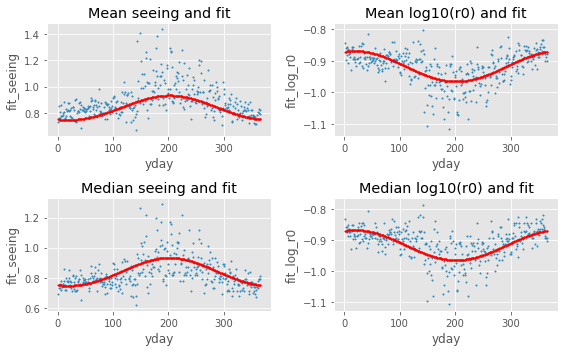

In [33]:
mpl.rcParams['figure.figsize'] = (8, 5)
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('Mean seeing and fit')
dimm.groupby(['yday'])['seeing'].mean().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[0,0])
axes[0,1].set_title('Mean log10(r0) and fit')
dimm.groupby(['yday'])['log_r0'].mean().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[0,1])
axes[1,0].set_title('Median seeing and fit')
dimm.groupby(['yday'])['seeing'].median().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[1,0])
axes[1,1].set_title('Median log10(r0) and fit')
dimm.groupby(['yday'])['log_r0'].median().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[1,1])

dimm.groupby(['yday'])['fit_seeing'].mean().reset_index().plot.scatter('yday', 'fit_seeing', s=2, c='r', ax=axes[0,0])
dimm.groupby(['yday'])['fit_log_r0'].mean().reset_index().plot.scatter('yday', 'fit_log_r0', s=2, c='r', ax=axes[0,1])
dimm.groupby(['yday'])['fit_seeing'].median().reset_index().plot.scatter('yday', 'fit_seeing', s=2, c='r', ax=axes[1,0])
dimm.groupby(['yday'])['fit_log_r0'].median().reset_index().plot.scatter('yday', 'fit_log_r0', s=2, c='r', ax=axes[1,1])

plt.tight_layout()

and also on a monthly one:

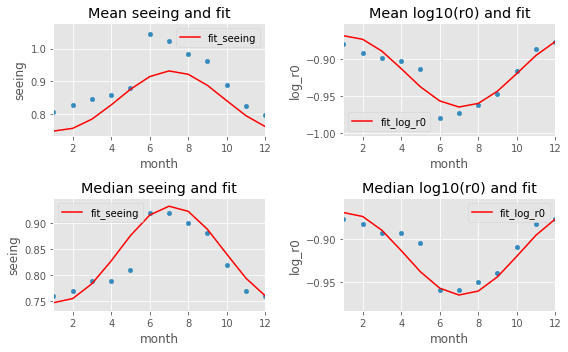

In [34]:
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('Mean seeing and fit')
dimm.groupby(['month'])['seeing'].mean().reset_index().plot.scatter('month', 'seeing', ax=axes[0,0])
axes[0,1].set_title('Mean log10(r0) and fit')
dimm.groupby(['month'])['log_r0'].mean().reset_index().plot.scatter('month', 'log_r0', ax=axes[0,1])
axes[1,0].set_title('Median seeing and fit')
dimm.groupby(['month'])['seeing'].median().reset_index().plot.scatter('month', 'seeing', ax=axes[1,0])
axes[1,1].set_title('Median log10(r0) and fit')
dimm.groupby(['month'])['log_r0'].median().reset_index().plot.scatter('month', 'log_r0', ax=axes[1,1])

dimm.groupby(['month'])['fit_seeing'].mean().reset_index().plot('month', 'fit_seeing', c='r', ax=axes[0,0])
dimm.groupby(['month'])['fit_log_r0'].mean().reset_index().plot('month', 'fit_log_r0', c='r', ax=axes[0,1])
dimm.groupby(['month'])['fit_seeing'].median().reset_index().plot('month', 'fit_seeing', c='r', ax=axes[1,0])
dimm.groupby(['month'])['fit_log_r0'].median().reset_index().plot('month', 'fit_log_r0', c='r', ax=axes[1,1])

plt.tight_layout()

# Seeing and log(r0) with fit by month

Now I check to see if subtraction of the model removes the obvious seasonal periodicity, first by day of year:

Text(0,0.5,'log10(r0) - fit log10(r0)')

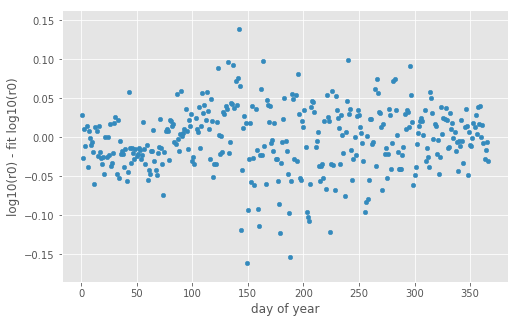

In [35]:
fig, axes = plt.subplots()
dimm.groupby('yday')['log_r0_fit_diff'].mean().reset_index().plot.scatter('yday', 'log_r0_fit_diff', ax=axes)
axes.set_xlabel('day of year')
axes.set_ylabel('log10(r0) - fit log10(r0)')

and then using monthly distributions:

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


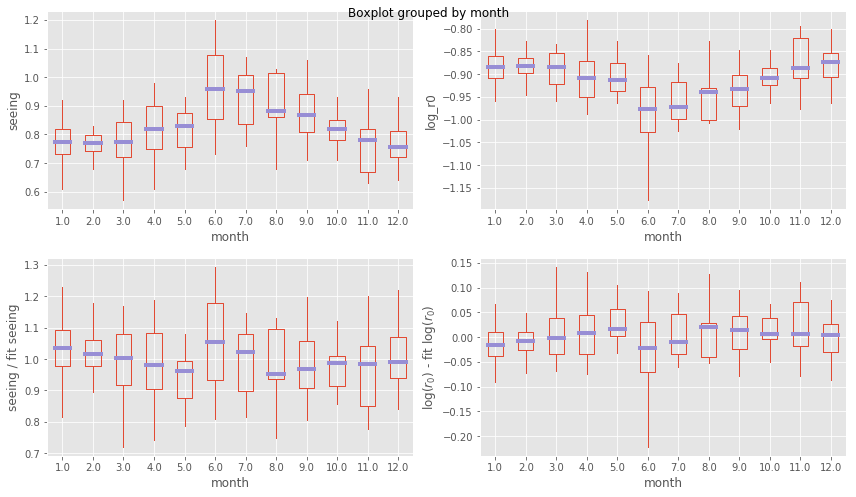

In [36]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2,2)
dimm.groupby('data_month').median().boxplot('log_r0', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0, 1])
dimm.groupby('data_month').median().boxplot('seeing', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0, 0])
dimm.groupby('data_month').median().boxplot('log_r0_fit_diff', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1, 1])
dimm.groupby('data_month').median().boxplot('fit_seeing_ratio', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1, 0])

# Label the data on the y axis, not the top
for ax in axes.flatten():
    ax.set_ylabel(ax.get_title())
    ax.set_title('')

axes[1, 1].set_ylabel('$\log(r_0)$ - fit $\log(r_0)$')
axes[1, 0].set_ylabel('seeing / fit seeing')
    
plt.tight_layout()

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


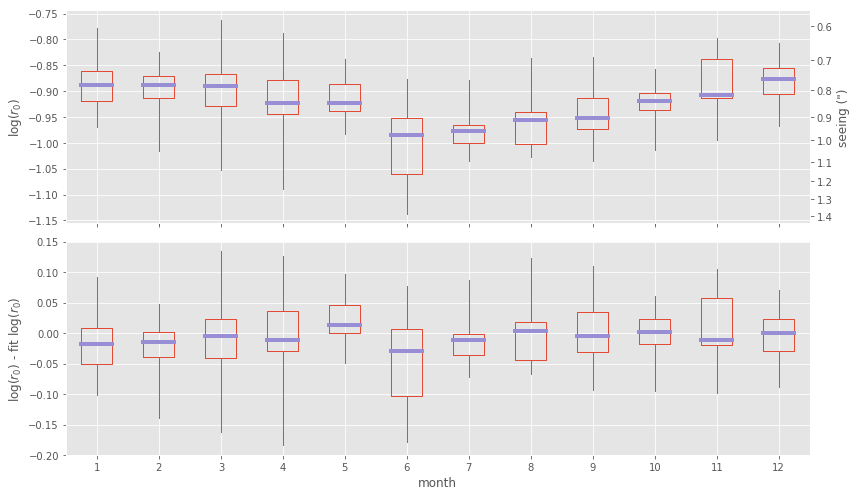

In [113]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
df = dimm.groupby('data_month').agg({'month': 'median', 'log_r0': 'mean', 'log_r0_fit_diff': 'mean'})
df.boxplot('log_r0', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0], whis='range')
df.boxplot('log_r0_fit_diff', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1], whis='range')

# Label the data on the y axis, not the top
for ax in axes.flatten():
    ax.set_ylabel(ax.get_title())
    ax.set_title('')
    ax.set_xticklabels(np.arange(1, 13, dtype=int))

right_axes = axes[0].twinx()
dimm.groupby('data_month').median().plot.scatter('log_r0', 'month', ax=right_axes)
seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.1), np.arange(2.0, 4.0, 0.4)), axis=0)
logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
right_axes.set_yticks(logr0_ticks)
right_axes.set_yticklabels(seeing_ticks)
right_axes.set_ylabel('seeing (")')
right_axes.set_ylim(axes[0].get_ylim())
right_axes.grid(False)

fig.suptitle('')
axes[0].set_xlabel('')
axes[1].set_ylabel('$\log(r_0)$ - fit $\log(r_0)$')
axes[0].set_ylabel('$\log(r_0)$')

plt.tight_layout()

# Check autocorrelation of residuals

Subtraction of the model should also make the periodicity of the autocorrelation function go away.

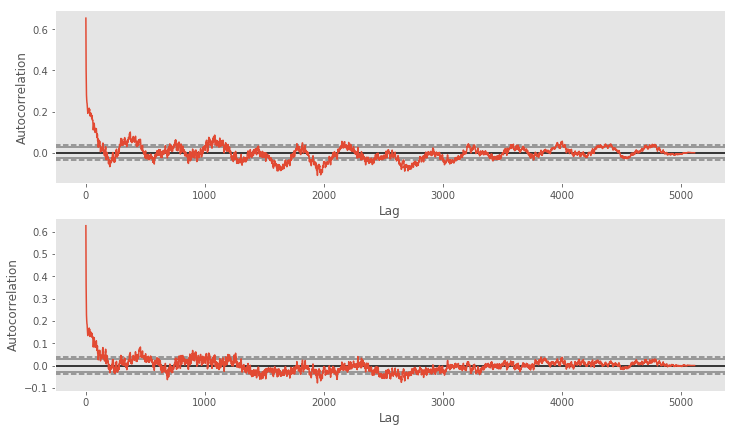

In [37]:
df = dimm.groupby('night')[['log_r0', 'log_r0_fit_diff']].mean().reset_index().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)

fig, axes = plt.subplots(2)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])

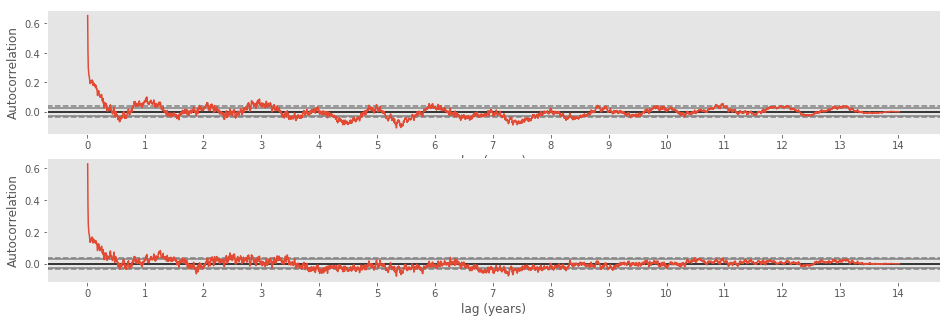

In [76]:
df = pd.DataFrame({'night': np.arange(dimm.night.min(), dimm.night.max()), 'dummy': 0}).set_index('night')
df['log_r0'] = dimm.groupby('night')['log_r0'].mean().copy()
df['log_r0_fit_diff'] = dimm.groupby('night')['log_r0_fit_diff'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)
fig, axes = plt.subplots(2)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])
for ax in axes:
    ax.set_xticks(np.arange(0, dimm.night.max()-dimm.night.min(),365))
    ax.set_xticklabels(np.arange(0, 15))
    ax.set_xlabel('lag (years)')

It looks like there may be a little periodic correlation left in the model-subtracted data (bottom), but much less than in the raw data (top).

The partial autocorrelation function measures the correlation from one night to the next. The plot below just ignores nights without data, which isn't really the correct thing to do.


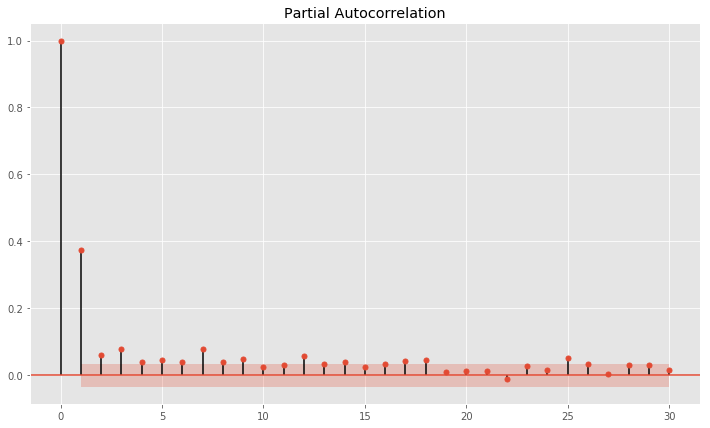

In [121]:
d = dimm.groupby('night')['log_r0_fit_diff'].mean()
fig = statsmodels.graphics.tsaplots.plot_pacf(d[~np.isnan(d)], lags=30)

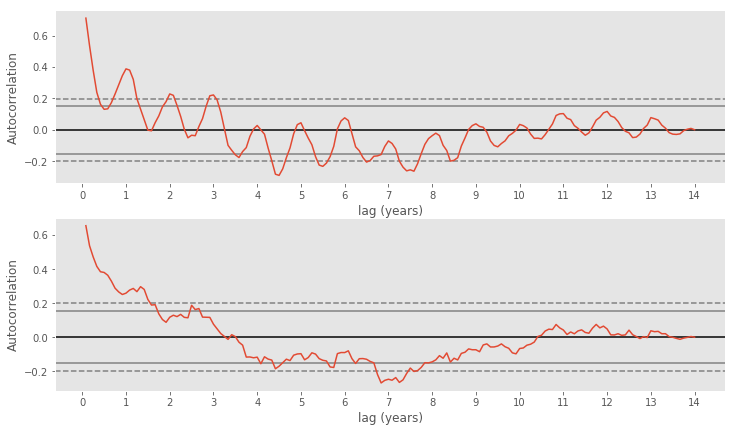

In [114]:
df = pd.DataFrame({'data_month': np.arange(dimm.data_month.min(), dimm.data_month.max()), 'dummy': 0}).set_index('data_month')
df['log_r0'] = dimm.groupby('data_month')['log_r0'].mean().copy()
df['log_r0_fit_diff'] = dimm.groupby('data_month')['log_r0_fit_diff'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])
for ax in axes:
    ax.set_xticks(np.arange(0, 6+dimm.data_month.max()-dimm.data_month.min(),12))
    ax.set_xticklabels(np.arange(0, 15))
    ax.set_xlabel('lag (years)')

# Distribution of residuals from seasonal fit

First, a simple shorthand for plotting histogram and overplotted distributions:

In [39]:
def hist_norm_gengamma(data, xlim, bins=30, npts=100, dists=[scipy.stats.norm]):
    mpl.rcParams['figure.figsize'] = (8, 5)
    norm_fit = scipy.stats.norm.fit(data)
    ggfit = scipy.stats.gengamma.fit(data)
    p3fit = scipy.stats.pearson3.fit(data)
    x = np.linspace(xlim[0], xlim[1], npts)
    fit_data = pd.DataFrame({'x': x,
                             'norm': scipy.stats.norm.pdf(x, loc=norm_fit[0], scale=norm_fit[1]),
                             'gen_gamma': scipy.stats.gengamma.pdf(x, ggfit[0], ggfit[1], loc=ggfit[2], scale=ggfit[3]),
                             'pearson3': scipy.stats.pearson3.pdf(x, p3fit[0], loc=p3fit[1], scale=p3fit[2])})
    fig, axes = plt.subplots()
    data.hist(bins=bins, normed=True, ax=axes)
    if scipy.stats.norm in dists:
        fit_data.plot('x', 'norm', c='g', ax=axes)
    if scipy.stats.gengamma in dists:
        fit_data.plot('x', 'gen_gamma', c='b', ax=axes)
    if scipy.stats.pearson3 in dists:
        fit_data.plot('x', 'pearson3', c='tab:brown', ax=axes)
    return fig

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


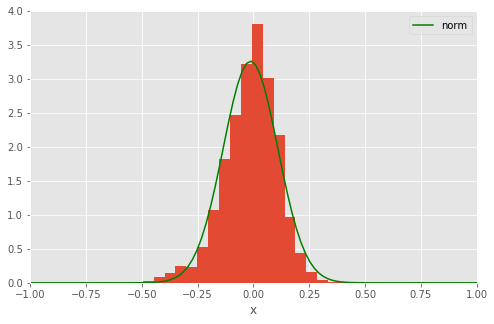

In [40]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig = hist_norm_gengamma(df.log_r0_fit_diff, (-1, 1))

Text(0.5,0,'$\\log(r_0)$ - seasonal fit $\\log(r_0)$')

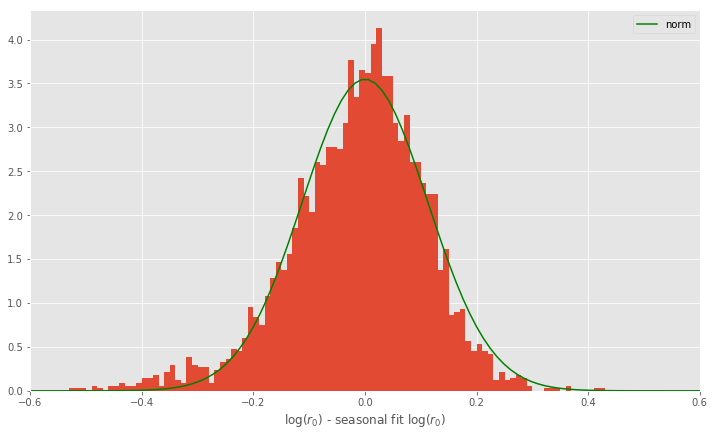

In [136]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1)
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=axes)

stdev = np.median(np.abs(df.log_r0_fit_diff))*1.4826
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='g', ax=axes)
axes.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')

((array([-3.53082163, -3.28896403, -3.15531807, ...,  3.15531807,
          3.28896403,  3.53082163]),
  array([-0.69153729, -0.52755934, -0.51292202, ...,  0.41066005,
          0.42247727,  0.77482758])),
 (0.12121737702302982, -0.012930854008250415, 0.98858365346032817))

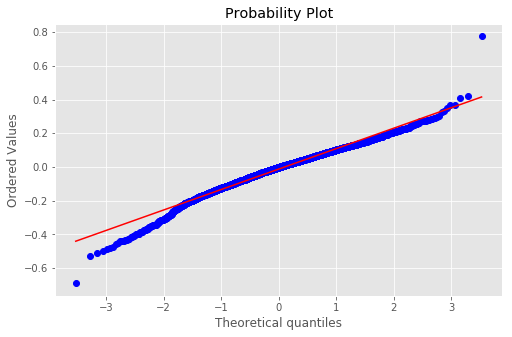

In [41]:
fig, axes = plt.subplots()
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
scipy.stats.probplot(df.log_r0_fit_diff, dist=scipy.stats.norm, plot=axes)

# Fit an AR model to the mean nightly log(r0)

I will be using an autoregressive model (generalized damped random walk) for the residuals from the seasonal model, following the notation and nomenclature of Cryer and Chan's *Time Series Analysis*.

I begin by modeling how the mean seeing over an entire night varies with time.

## Divide the data into runs of consecutive nights without missing nights¶

Tools for fitting AR models assume sequences of consecutive, regularly spaced points without gaps. So, instead of making a single fit, I will fit to each such sequence in the data and look at the distributions of fit parameters.

The first step in doing this is to divide the DIMM data into subsequences on which the model fits may be performed.

In [42]:
dimm_nightly_mean = dimm[~ np.isnan(dimm.log_r0_fit_diff)].query('~ twilight24').groupby('night').mean().reset_index(drop=False)
#dimm_nightly_mean = dimm[~ np.isnan(dimm.log_r0_fit_diff)].groupby('night').mean().reset_index(drop=False)

nights = dimm_nightly_mean.night.values
prev_nights = np.roll(nights, 1)
dimm_nightly_mean['nseq'] = (~ ((nights == 1+prev_nights) | (nights == 1))).cumsum().astype(int)

dimm_nightly_mean

,night,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,yday,am,solar_zd,twilight,twilight24,fit_log_r0,fit_r0,fit_seeing,log_r0_fit_diff,fit_seeing_ratio,nseq
0,1,0.718889,0.142109,-0.849685,0.549167,3.0,2004.0,3.0,53081.121528,77.0,0.000000,137.999944,0.0,0.0,-0.890212,0.128762,0.784935,0.040527,0.915859,0
1,7,0.685446,0.152793,-0.823622,0.520841,3.0,2004.0,3.0,53087.201389,83.0,0.514851,136.358253,0.0,0.0,-0.894563,0.127478,0.792838,0.070942,0.864525,1
2,8,0.803762,0.134643,-0.884471,0.623770,3.0,2004.0,3.0,53088.201389,84.0,0.514851,136.655154,0.0,0.0,-0.895304,0.127261,0.794191,0.010833,1.012087,1
3,9,0.670400,0.157014,-0.812596,0.508051,3.0,2004.0,3.0,53089.200069,85.0,0.510000,137.052961,0.0,0.0,-0.896049,0.127043,0.795556,0.083454,0.842682,1
4,10,0.721386,0.141976,-0.850390,0.551403,3.0,2004.0,3.0,53090.201389,86.0,0.514851,137.244236,0.0,0.0,-0.896803,0.126823,0.796938,0.046413,0.905199,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,5114,0.802827,0.129592,-0.893487,0.622053,3.0,2018.0,171.0,58194.203125,76.0,0.520408,135.086868,0.0,0.0,-0.889999,0.128825,0.784549,-0.003488,1.023292,507
3281,5115,0.926634,0.110760,-0.958888,0.729477,3.0,2018.0,171.0,58195.209939,77.0,0.548387,135.856711,0.0,0.0,-0.890698,0.128618,0.785813,-0.068190,1.179210,507
3282,5116,0.690061,0.151891,-0.826521,0.524800,3.0,2018.0,171.0,58196.201389,78.0,0.515152,135.479637,0.0,0.0,-0.891394,0.128412,0.787073,0.064873,0.876762,507
3283,5117,0.904859,0.116567,-0.942034,0.711141,3.0,2018.0,171.0,58197.201389,79.0,0.515152,135.783784,0.0,0.0,-0.892104,0.128202,0.788360,-0.049930,1.147797,507


Then, I build a utility function to actually do the fit on a subsequence, and apply it to each subsequence with at least 7 data points.

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


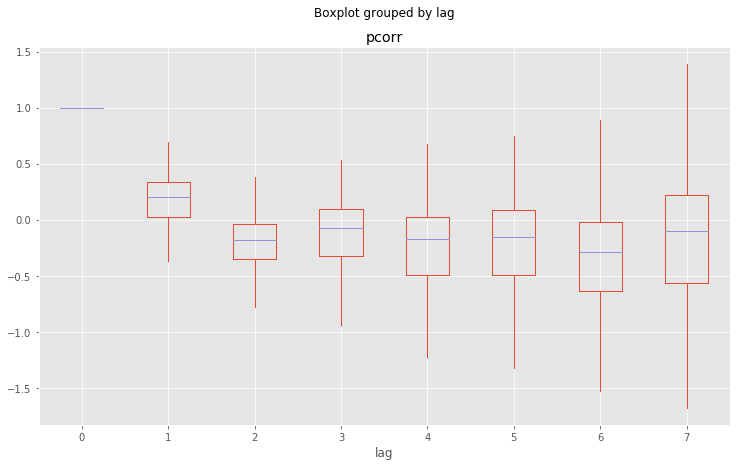

In [207]:
nlags = 7
def pacf(df):
    if len(df) > nlags:
        lag_vals, confint = statsmodels.tsa.stattools.pacf(df.log_r0_fit_diff.values, nlags, alpha=0.05)
        result = {'pcorr': lag_vals,
                  'pcorr_low': confint[:,0],
                  'pcorr_high': confint[:,1],
                  'lag': np.arange(nlags+1),
                  'nseq': df.nseq[:nlags+1]}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    
df = dimm_nightly_mean.groupby('nseq').apply(pacf)
mpl.rcParams['figure.figsize'] = (12, 7)
df.boxplot('pcorr', 'lag', showfliers=False, showcaps=False)

In [43]:
def arfit(df):
    if len(df) >= 7:
        fit = AR(df.log_r0_fit_diff.values).fit(1)
        result = {'const': [fit.params[0]],
                  'const_stderr': [fit.bse[0]],
                  'L1': [fit.params[1]],
                  'L1_stderr': [fit.bse[1]],
                  'sigma2': [fit.sigma2],
                  'num_nights': len(df)}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    
nightly_arfits = dimm_nightly_mean.groupby('nseq').apply(arfit)
nightly_arfits

,,L1,L1_stderr,const,const_stderr,num_nights,sigma2
nseq,,,,,,,
2,0,-0.055638,0.283377,-0.024663,0.025072,14,0.006812
4,0,0.462589,0.229194,-0.012501,0.029995,19,0.011972
12,0,0.400141,0.231497,-0.035722,0.039299,16,0.012499
15,0,0.605213,0.235097,0.007133,0.023725,14,0.005460
17,0,0.238191,0.454590,-0.004981,0.073341,8,0.025743
...,...,...,...,...,...,...,...
503,0,0.240513,0.288698,0.001472,0.020640,15,0.005074
504,0,0.275309,0.134436,-0.022664,0.013165,51,0.007630
505,0,0.254803,0.203032,-0.014668,0.017696,24,0.006431


### Is the constant term consistant with 0?

If the seasonal fit was correct, the constant term in the AR fit should be 0. I'll start by looking at the distribution for the fits I've made, normalized by the uncertainty in the fit value:

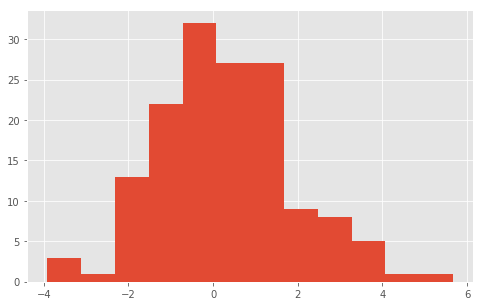

In [44]:
(nightly_arfits.const/nightly_arfits.const_stderr).hist(bins=12)

In [45]:
(nightly_arfits.const/nightly_arfits.const_stderr).describe()

count    149.000000
mean       0.333618
std        1.628762
min       -3.918918
25%       -0.793777
50%        0.185751
75%        1.379449
max        5.670702
dtype: float64

In [46]:
np.average(nightly_arfits.const, weights=nightly_arfits.const_stderr**-2)

0.010883913868511223

### The sigma of the innovation

The innovation corresponds to the step size in a random walk. In our fits to different subsets of our data, how consistant was this?

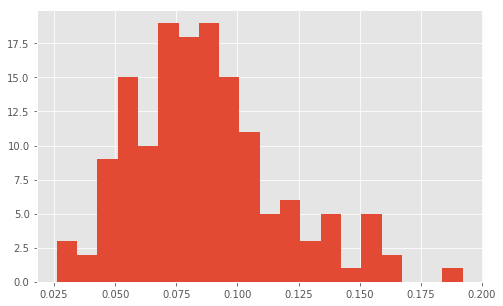

In [47]:
np.sqrt(nightly_arfits.sigma2).hist(bins=20)

In [48]:
np.sqrt(nightly_arfits.sigma2).describe()

count    149.000000
mean       0.087127
std        0.030314
min        0.026200
25%        0.066164
50%        0.084014
75%        0.102987
max        0.192132
Name: sigma2, dtype: float64

### The regressive (L1) term¶

The regressing terms in an AR model correspond to the weight of the previous data value(s). 

In [49]:
mean_nightly_L1 = np.average(nightly_arfits.L1, weights=nightly_arfits.L1_stderr**-2)
mean_nightly_L1

0.21291874427875448

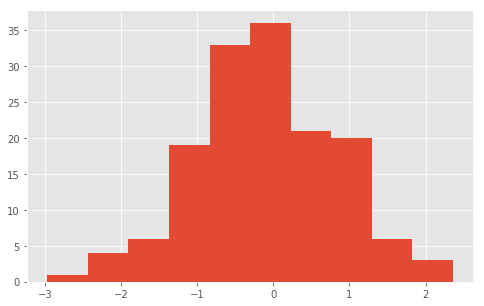

In [50]:
((nightly_arfits.L1 - mean_nightly_L1)/nightly_arfits.L1_stderr).hist()

So, for our regressive model, we need innovations with a standard deviation of 0.08, and and L1 term of 0.2.

## Overplot the expected variance on the actual distribution

The distribution of points resulting from an AR1 model can be calculated using equation 4.3.3 of Cryer and Chan:

In [214]:
stdev = np.round(np.sqrt((0.08**2)/(1-0.2**2)), 3)
stdev

0.082000000000000003

Text(0.5,0,'$\\log(r_0)$ - seasonal fit $\\log(r_0)$')

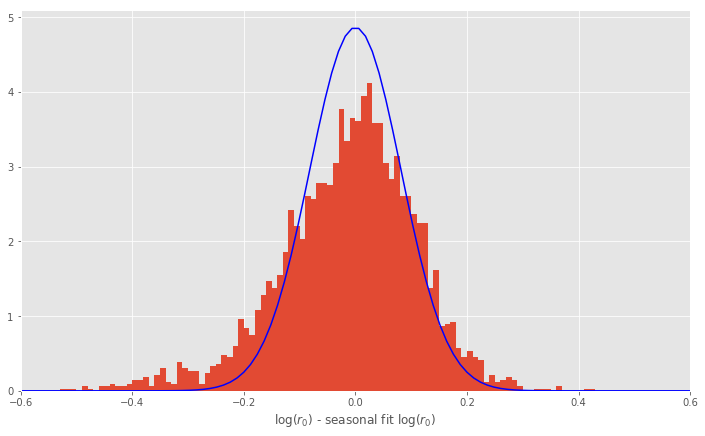

In [215]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1)
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=axes)

#stdev = np.median(np.abs(df.log_r0_fit_diff))*1.4826
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='b', ax=axes, legend=False)
axes.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')

# Model short term seeing variations

Seeing does not only vary night to night, but on short time scales as well. I also model the seeing variation (in 5 minute increments) using an AR model.

## Divide seeing into unbroken sequences sampled every 5 minutes

In [51]:
dimm['seq'] = (np.isnan(dimm.seeing)!=np.isnan(dimm.seeing.shift())).cumsum()
dimm.loc[np.isnan(dimm.seeing), 'seq'] = 0
dimm['seq'] = ((dimm.seq + 1)/2).astype(np.int)
dimm

,seeing,r0,log_r0,vk_seeing,month,year,data_month,mjd,yday,night,am,solar_zd,twilight,twilight24,fit_log_r0,fit_r0,fit_seeing,log_r0_fit_diff,fit_seeing_ratio,seq
time,,,,,,,,,,,,,,,,,,,,
2004-03-17 02:30:00,NaN,NaN,NaN,NaN,3,2004,NaN,53081.104167,77,1,False,133.917644,False,False,-0.890200,0.128766,0.784913,NaN,NaN,0
2004-03-17 02:35:00,0.7400,0.136581,-0.864611,0.567158,3,2004,3.0,53081.107639,77,1,False,134.778300,False,False,-0.890203,0.128765,0.784917,0.025592,0.942775,1
2004-03-17 02:40:00,0.8800,0.114852,-0.939861,0.688482,3,2004,3.0,53081.111111,77,1,False,135.624071,False,False,-0.890205,0.128764,0.784922,-0.049656,1.121131,1
2004-03-17 02:45:00,0.7000,0.144385,-0.840477,0.532723,3,2004,3.0,53081.114583,77,1,False,136.454055,False,False,-0.890207,0.128763,0.784926,0.049731,0.891804,1
2004-03-17 02:50:00,0.7600,0.132987,-0.876192,0.584417,3,2004,3.0,53081.118056,77,1,False,137.267298,False,False,-0.890210,0.128763,0.784930,0.014017,0.968239,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21 09:50:00,0.7550,0.133867,-0.873326,0.580100,3,2018,171.0,58198.409722,80,5118,True,103.104634,True,True,-0.892971,0.127947,0.789936,0.019645,0.955773,11651
2018-03-21 09:55:00,0.7440,0.135846,-0.866952,0.570608,3,2018,171.0,58198.413194,80,5118,True,102.033569,True,True,-0.892973,0.127946,0.789941,0.026022,0.941843,11651
2018-03-21 10:00:00,0.7220,0.139986,-0.853916,0.551649,3,2018,171.0,58198.416667,80,5118,True,100.961032,True,True,-0.892976,0.127945,0.789945,0.039060,0.913987,11651


## Make an AR fit to each sequence longer than some threshhold

In [52]:
min_seq_len = 60*3/5

def short_arfit(df):
    if len(df) >= min_seq_len:
        fit = AR(df.log_r0_fit_diff.values).fit(1)
        if np.isnan(fit.params[0]):
            return None
        
        result = {'const': [fit.params[0]],
                  'const_stderr': [fit.bse[0]],
                  'L1': [fit.params[1]],
                  'L1_stderr': [fit.bse[1]],
                  'sigma2': [fit.sigma2],
                  'n': len(df)}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    

In [53]:
short_arfits = dimm.query('~ twilight24').groupby('seq').apply(short_arfit)
#short_arfits = dimm.groupby('seq').apply(short_arfit)
short_arfits.index = short_arfits.index.droplevel(1)
short_arfits['count'] = dimm.reset_index().groupby('seq').count()['seeing']
short_arfits['month'] = dimm[['seq', 'month']].groupby('seq').median()
short_arfits['mjd'] = dimm[['seq', 'mjd']].groupby('seq').median()
short_arfits['yday'] = dimm[['seq', 'yday']].groupby('seq').median().astype(int)
short_arfits['sigma'] = np.sqrt(short_arfits.sigma2)
short_arfits

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


,L1,L1_stderr,const,const_stderr,n,sigma2,count,month,mjd,yday,sigma
seq,,,,,,,,,,,
3,0.851233,0.054785,0.009587,0.005964,101,0.001959,117,3,53087.197917,83,0.044258
4,0.781899,0.064169,0.002828,0.007270,101,0.005145,115,3,53088.201389,84,0.071730
5,0.615398,0.085339,0.032756,0.010309,88,0.004477,102,3,53089.154514,85,0.066908
8,0.164223,0.098958,0.039457,0.006757,101,0.002364,129,3,53090.201389,86,0.048625
9,0.552098,0.075191,0.047515,0.008845,107,0.002059,119,4,53103.215278,99,0.045380
...,...,...,...,...,...,...,...,...,...,...,...
11646,0.455395,0.091511,-0.001820,0.006785,98,0.004367,124,3,58194.203125,76,0.066082
11648,0.605043,0.088274,-0.023734,0.006917,83,0.001502,97,3,58195.253472,77,0.038757
11649,0.835738,0.055978,0.012371,0.005860,99,0.002066,125,3,58196.204861,78,0.045451


## Check the AR fit results

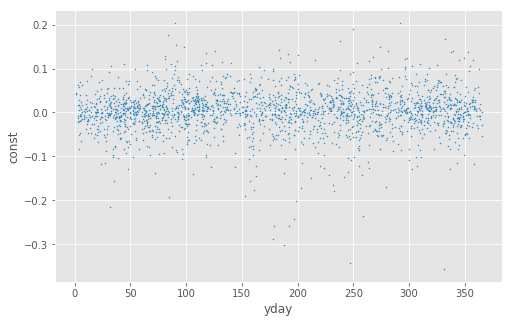

In [54]:
short_arfits.plot.scatter('yday', 'const', s=1)

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


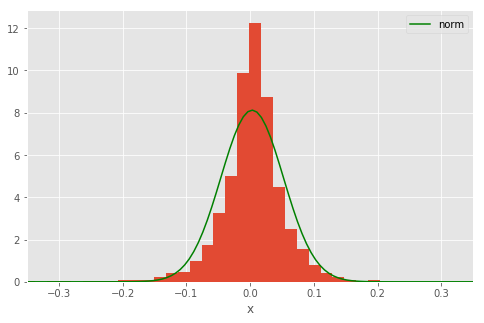

In [55]:
fig = hist_norm_gengamma(short_arfits.const, (-0.35, 0.35))

## Sigma of the innovation

In [56]:
short_arfits.sigma.describe()

count    2145.000000
mean        0.054796
std         0.013399
min         0.024215
25%         0.045436
50%         0.052450
75%         0.061707
max         0.122013
Name: sigma, dtype: float64

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


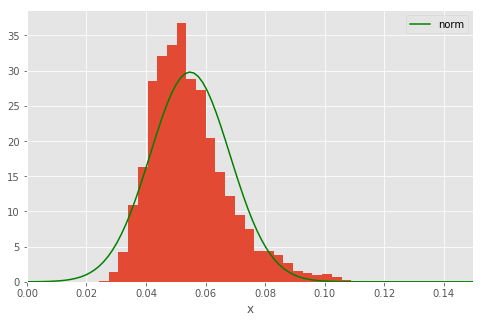

In [57]:
fig = hist_norm_gengamma(short_arfits.sigma, (0, 0.15))

#### Does sigma vary by time of year?

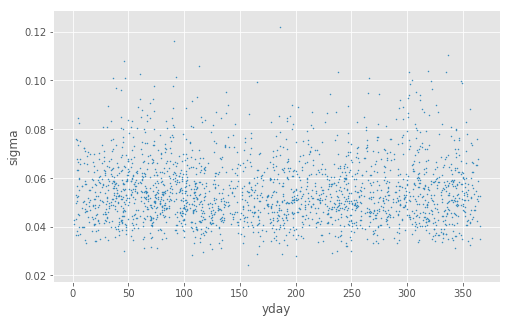

In [58]:
short_arfits.plot.scatter('yday', 'sigma', s=1)

#### Is sigma correlated night to night?

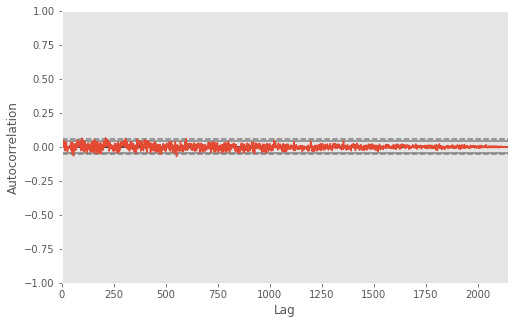

In [59]:
pd.plotting.autocorrelation_plot(short_arfits.sigma)

## Regressive (L1) term

In [60]:
df = short_arfits.query('n > 4*12')
mean_short_L1 = np.average(df.L1, weights=df.L1_stderr**-2)
mean_short_L1

0.71735161292660432

In [61]:
df.L1.describe()

count    1408.000000
mean        0.651605
std         0.165346
min        -0.026831
25%         0.551569
50%         0.674582
75%         0.776876
max         1.245464
Name: L1, dtype: float64

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


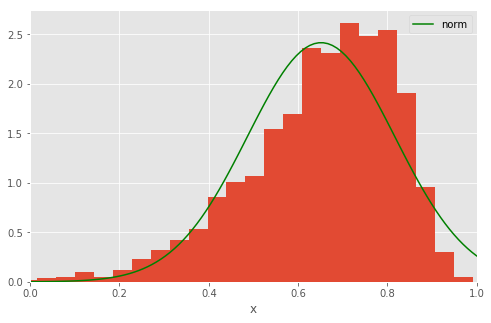

In [62]:
fig = hist_norm_gengamma(df.L1, (0, 1))

That looks pretty skew. What if I only look at points with the highest precision measuerments of L1 (S/N>10)?

/data/des60.b/data/neilsen/anaconda/envs/ehn35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


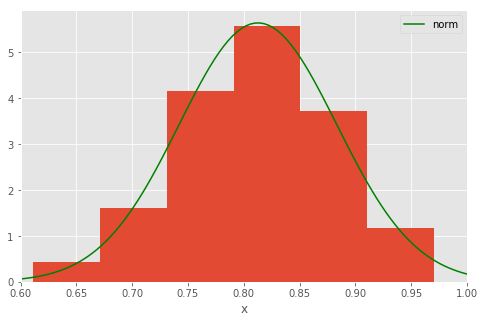

In [63]:
fig = hist_norm_gengamma(short_arfits[mean_short_L1/short_arfits.L1_stderr >10 ]['L1'], xlim=(0.6,1), bins=10)

#### Does L1 vary by time of year?


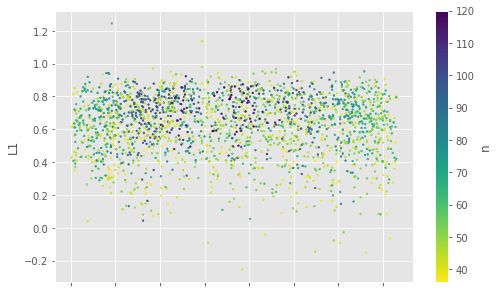

In [64]:
short_arfits.plot.scatter('yday', 'L1', c='n', s=3, cmap='viridis_r')

#### Is L1 correlated over time?

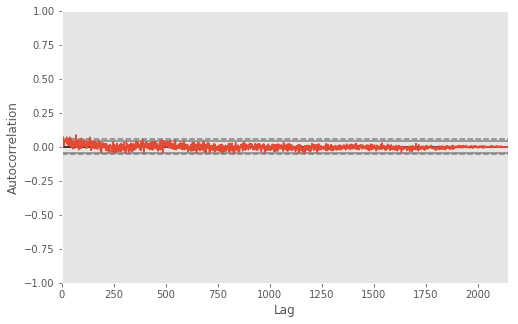

In [65]:
pd.plotting.autocorrelation_plot(short_arfits.L1)

## Relationships between fit terms


### Const and sigma

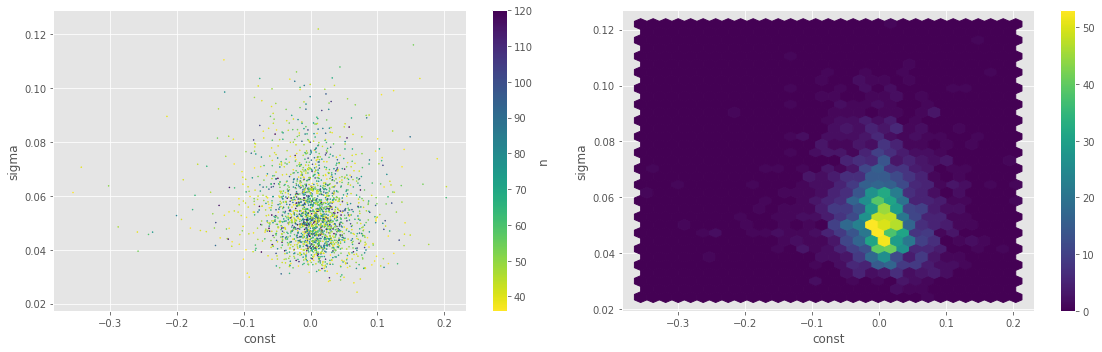

In [66]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('const', 'sigma', c='n', s=1, cmap='viridis_r', ax=axes[0])
short_arfits.plot.hexbin('const', 'sigma', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

### Const and L1

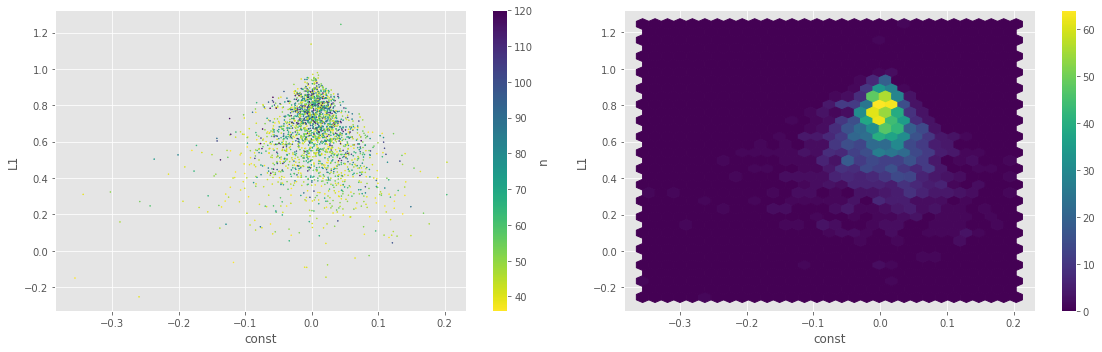

In [67]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('const', 'L1', s=1, c='n', ax=axes[0], cmap='viridis_r')
short_arfits.plot.hexbin('const', 'L1', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

### L1 and sigma

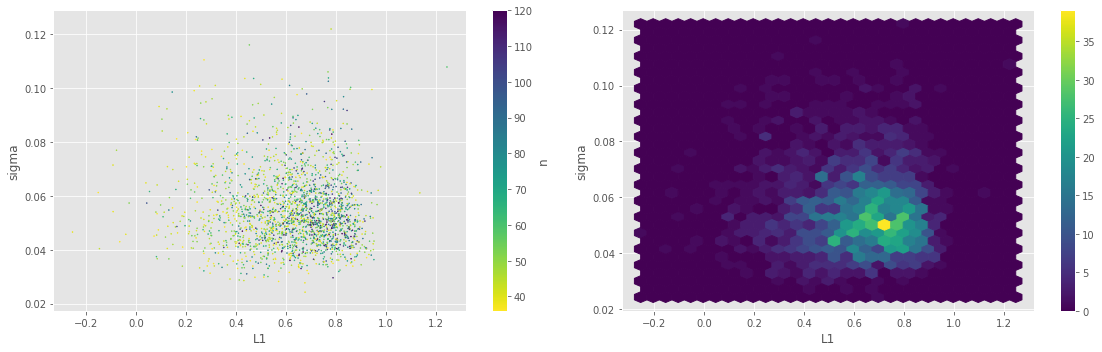

In [68]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('L1', 'sigma', c='n', s=1, ax=axes[0], cmap='viridis_r')
short_arfits.plot.hexbin('L1', 'sigma', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

## Short AR conclusion

We need an innovation with a standard deviation of 0.05 and and L1 term of 0.7.